<a href="https://colab.research.google.com/github/muhammadmo/Deep_Learning_COVID19/blob/main/medical_image_classification_covid_19_using_a_light_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadmoosavi","key":"1fa1bc8aae4bfd517b860f44615ff8d9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sachinkumar413/covid-pneumonia-normal-chest-xray-images

 96% 265M/277M [00:08<00:00, 16.7MB/s]
100% 277M/277M [00:09<00:00, 32.3MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "covid-pneumonia-normal-chest-xray-images.zip"

with ZipFile(file_name,'r') as zipp:
  zipp.extractall()
print('done') 

done


In [ ]:
pip install split_folders

In [ ]:
import splitfolders
input_folder = "/content/dataset"
output = "/content/splited_dataset"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .1, .2)) 

Copying files: 5228 files [00:01, 3421.96 files/s]


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np             
import pandas as pd           

train_path = '/content/splited_dataset/train'
test_path = '/content/splited_dataset/test'
valid_path = '/content/splited_dataset/val'

#set defult image size
batch_size = 128
img_width = 256
img_height = 256

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='sparse',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='sparse',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='sparse', 
      batch_size=batch_size
      )


Found 3659 images belonging to 3 classes.
Found 1047 images belonging to 3 classes.
Found 522 images belonging to 3 classes.


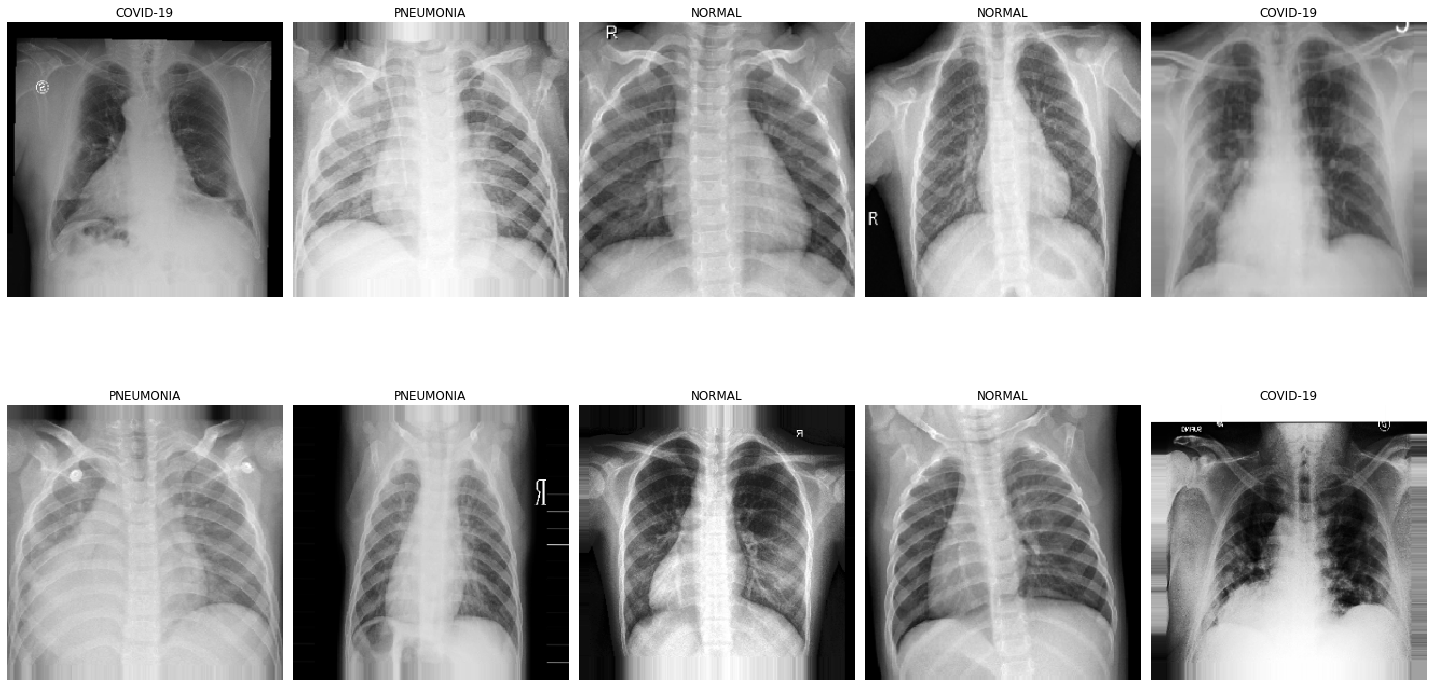

In [ ]:
plt.figure(figsize=(20, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'COVID-19', 1:'NORMAL', 2:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
#building CNN stracture
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(3,activation="softmax"))
cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 32)      

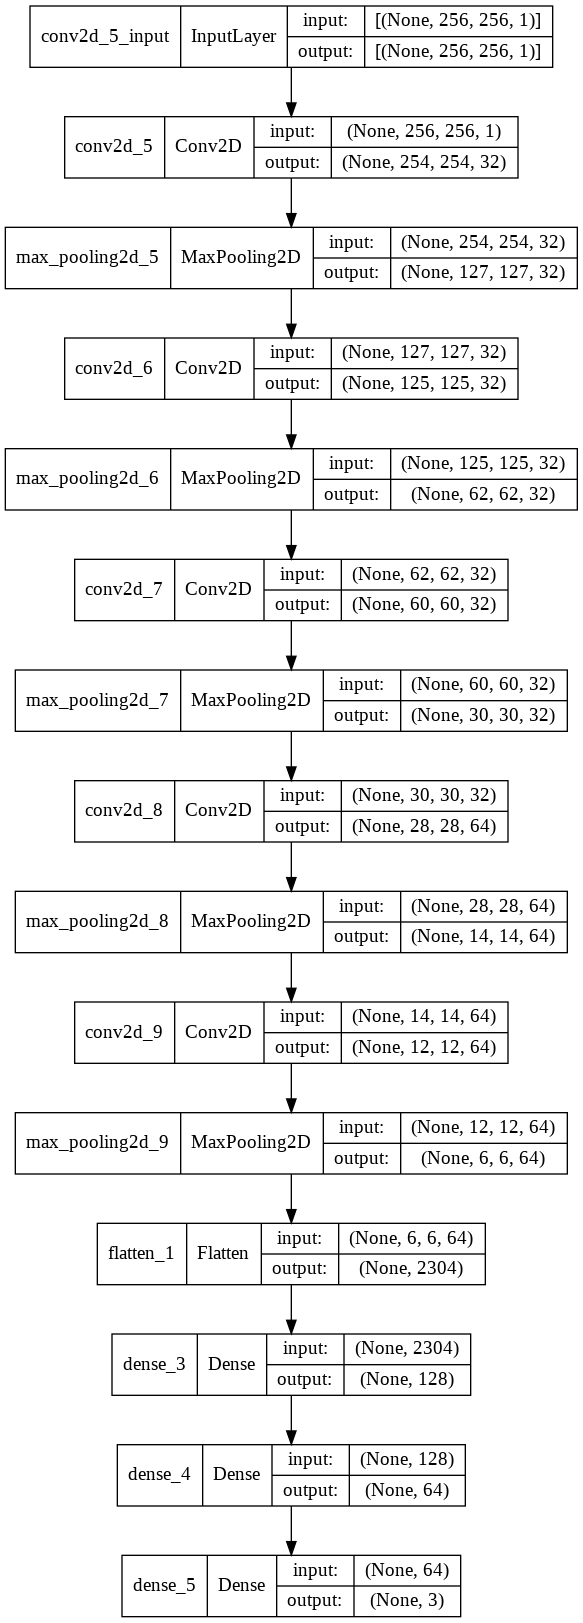

In [ ]:
#show model
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
#early stopping
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.0717633274751026, 1: 0.9672217816547714, 2: 0.967989417989418}


In [ ]:
history = cnn.fit(train,
                    batch_size=128,
                    epochs=20,
                    validation_data=valid)

Epoch 1/20
29/29 [==============================] - 26s 879ms/step - loss: 0.1102 - accuracy: 0.9596 - val_loss: 0.0916 - val_accuracy: 0.9693
Epoch 2/20
29/29 [==============================] - 26s 878ms/step - loss: 0.0866 - accuracy: 0.9705 - val_loss: 0.1182 - val_accuracy: 0.9521
Epoch 3/20
29/29 [==============================] - 25s 856ms/step - loss: 0.0959 - accuracy: 0.9664 - val_loss: 0.0872 - val_accuracy: 0.9655
Epoch 4/20
29/29 [==============================] - 25s 851ms/step - loss: 0.1028 - accuracy: 0.9642 - val_loss: 0.0919 - val_accuracy: 0.9732
Epoch 5/20
29/29 [==============================] - 25s 853ms/step - loss: 0.0903 - accuracy: 0.9675 - val_loss: 0.0799 - val_accuracy: 0.9598
Epoch 6/20
29/29 [==============================] - 25s 843ms/step - loss: 0.0886 - accuracy: 0.9708 - val_loss: 0.0709 - val_accuracy: 0.9770
Epoch 7/20
29/29 [==============================] - 25s 854ms/step - loss: 0.0853 - accuracy: 0.9694 - val_loss: 0.0876 - val_accuracy: 0.9674

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.0717633274751026, 1: 0.9672217816547714, 2: 0.967989417989418}


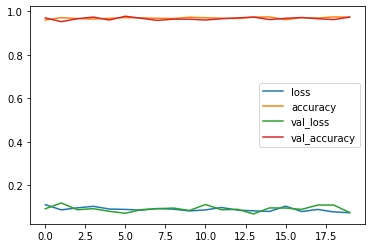

In [ ]:
pd.DataFrame(cnn.history.history).plot()

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

9/9 [==============================] - 2s 233ms/step - loss: 0.1433 - accuracy: 0.9628
The testing accuracy is : 96.27507328987122 %


In [ ]:
preds = cnn.predict(test,verbose=1)

9/9 [==============================] - 2s 244ms/step


In [ ]:
import numpy as np
rounded_labels=np.argmax(preds, axis=1)
rounded_labels[1]

0

In [ ]:
from sklearn.metrics import confusion_matrix
cmm = confusion_matrix(rounded_labels, test.classes)
cmm

array([[319,   2,   2],
       [  3, 346,  15],
       [  4,  13, 343]])

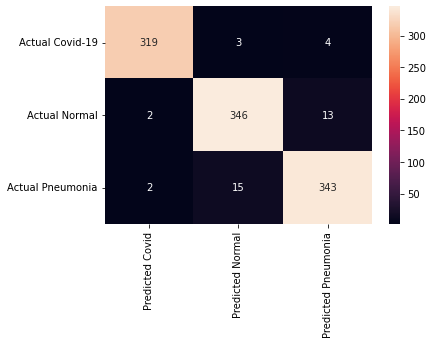

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, rounded_labels, labels=[0, 1, 2]),index=["Actual Covid-19", "Actual Normal", "Actual Pneumonia"],
columns=["Predicted Covid", "Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,y_pred=rounded_labels,target_names =['Covid-19','NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

    Covid-19       0.99      0.98      0.98       326
      NORMAL       0.95      0.96      0.95       361
   PNEUMONIA       0.95      0.95      0.95       360

    accuracy                           0.96      1047
   macro avg       0.96      0.96      0.96      1047
weighted avg       0.96      0.96      0.96      1047

